# Práctica del módulo NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import re
from collections import Counter

from spacy.lang.es.stop_words import STOP_WORDS

import gensim
from gensim.models import Word2Vec

import spacy
import lemminflect
spacy_lemmas = spacy.load('en_core_web_sm')

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

In [2]:
aiv5 = pd.read_csv("Amazon_Instant_Video_5.csv")
a5 = pd.read_csv("Automotive_5.csv")
dm5 = pd.read_csv("Digital_Music_5.csv")
mi5 = pd.read_csv("Musical_Instruments_5.csv")
plg5 = pd.read_csv("Patio_Lawn_and_Garden_5.csv")

reviews = pd.concat([aiv5,a5,dm5,mi5,plg5], ignore_index=True).dropna(subset=['reviewText','overall']).sample(frac=1)
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
26887,ADCFUY7WTZA6A,B00005O54Q,Jimmy Garcia,"[2, 2]",I was really impressed with this release. It h...,5,An Essential For Jay's Fans!!!,1158364800,"09 16, 2006"
28556,A28WBUWQIZGK6D,B00000ADG2,Book maniac,"[2, 2]","When I first listened to this album, I expecte...",5,It grows on you.,1001289600,"09 24, 2001"
47741,A120ULF73SUTI9,B0061O2O8K,"J. W. Kennedy ""kennedy610""","[39, 43]","""Your house is sitting on the stream we drank ...",5,Brome is the Best!,1329177600,"02 14, 2012"
10003,ALHWZSTAELK9I,B007OSL3DY,Scott,"[3, 3]",I installed this on my 2009 F150. It's a fancy...,4,"Easy as pie, but wobbly",1363478400,"03 17, 2013"
8661,A1EDBI6TBKP9CO,B008BQG3RE,Grants Book Trade,"[3, 3]","great show, got hooked watching seasons one an...",5,"Love it,",1382486400,"10 23, 2013"


# 2. Análisis de sentimiento

Me traigo mi función de preprocesado de textos y la amplío con nuevas funciones (lemmatizers, ngrams...)

In [3]:
def preprocess_texts(texts, **kwargs):
    
    processed_texts = [] # Aquí me guardaré los textos procesados en forma de lista
    
    for text in texts:
        
        tokens = [] # Aquí se guardan los tokens que conforman cada texto
        
        # Comenzando con el preprocesado completo de gensim.utils.simple_preprocess()
        if 'simple_gensim' in kwargs and kwargs['simple_gensim']:
            rawtokens = [token for token in gensim.utils.simple_preprocess(text)]
            
        # Si decido aplicar un lemmatizer como split inicial
        elif 'lemmatizer' in kwargs:
            lemmas = kwargs['lemmatizer'](text)
            rawtokens = [token._.lemma() for token in lemmas]
            
        # Hago un split y utilizo tan solo mi preprocesado adicional
        else: rawtokens = text.split()
        
        # Aplico reglas adicionales de preprocesado.
        for token in rawtokens:
            if 'lower' in kwargs and kwargs['lower']: token = token.lower()
            if 'only_alpha' in kwargs and kwargs['only_alpha']: token = re.sub('[^a-zA-Z]+', '', token)
            elif 'regex' in kwargs: token = re.sub(kwargs['regex'], '', token)
            if 'stop_words' in kwargs and token in kwargs.get('stop_words'): token = None

            if token: tokens.append(token)
                
        # Genero N-Gramas
        if 'ngrams' in kwargs:
            
            ngrams = [] # Aquí guardaré los ngramas que reemplazarán a la lista de tokens
            
            # Se puede utilizar una lista de varios ngramas
            if type(kwargs['ngrams']) is list or type(kwargs['ngrams']) is tuple:
                for ngram in kwargs['ngrams']:
                    if ngram == 1: ngrams = tokens
                    else:
                        for i in range(len(tokens)-ngram):
                            ngrams.append(" ".join(tokens[i:i+ngram]))
            
            # También se puede indicar un valor entero como única medida para el ngrama
            else:
                for i in range(len(tokens)-kwargs['ngrams']):
                    ngrams.append(" ".join(tokens[i:i+kwargs['ngrams']]))
                
            tokens = ngrams
        
        processed_texts.append(tokens)
        
    return processed_texts

Probaré diferentes modelos con diferentes tipos de preprocesado y al final compararé mis resultados.

Comenzaré construyéndome un corpus que contenga tan solo el texto y una categoría ("muy bueno", "bueno" y "no tan bueno").

In [4]:
reviews = reviews[['reviewText','overall']]
    
reviews.overall = reviews.overall.apply(lambda x: 'very_good' if x == 5 else 'good' if x > 3 else 'not_so_good')

In [5]:
reviews

,reviewText,overall
26887,I was really impressed with this release. It h...,very_good
28556,"When I first listened to this album, I expecte...",very_good
47741,"""Your house is sitting on the stream we drank ...",very_good
10003,I installed this on my 2009 F150. It's a fancy...,good
8661,"great show, got hooked watching seasons one an...",very_good
...,...,...
1943,The first grave encounters I really enjoyed. D...,not_so_good
6497,this is by far the best cop show on tv. its re...,very_good
36446,Yes this product is simple and expensive enoug...,very_good
4191,My 4 year old loves this show. She learns abo...,good


In [6]:
reviews.overall.value_counts()

very_good      29874
good           11442
not_so_good     8665
Name: overall, dtype: int64

He decidido realizar esta clasificación debido a que hay demasiadas críticas positivas frente a críticas neutras y negativas. Para saber si dentro de las críticas "no positivas" podemos tener distintos niveles sería conveniente hacer un split y entrenarlas a parte como un conjunto diferente.

Ahora me interesa hacer un split en train y test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews.reviewText,
    reviews.overall,
    train_size=0.80,
    test_size=0.20,
)

Ahora utilizaré el tf-idf de mi corpus de entrenamiento para obtener las palabras más relevantes que detectan el sentimiento y comprobar si tiene sentido, para ello probaré diferentes tipos de preprocesado.

In [8]:
def draw_chi2(Xcorpus, Ycorpus, tfidf):
    # Compute the chi-squared score for each word in the training set and show the values
    i = 15

    chi2score = chi2(Xcorpus, Ycorpus)[0]
    scores = list(zip(tfidf.get_feature_names(), chi2score))
    sorted_scores = sorted(scores, key=lambda x:x[1])
    topchi2 = list(zip(*sorted_scores[-i:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]

    plt.figure(figsize=(12, 8))
    plt.barh(x,topchi2[1], align='center', alpha=0.5)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=12)
    plt.xlabel('$\chi^2$', fontsize=26)
    plt.ylabel('word', fontsize=16)
    plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show();

Con todo pasado a minúsculas, quitando caracteres no alfabéticos y teniendo en cuenta bigramas y trigramas:

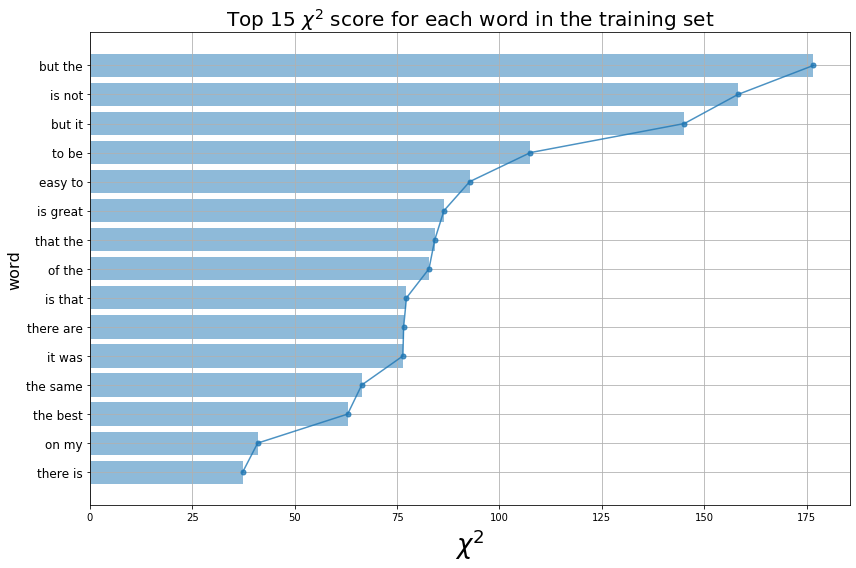

In [9]:
X_train_ = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lower=True, only_alpha=True)):
    X_train_[ix] = " ".join(processed_text)
    
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=0.05,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_ = cv.fit_transform(X_train_)

draw_chi2(X_train_, y_train, cv)

No está mal del todo, aunque aparecen muchos verbos auxiliares y determinantes, veamos qué pasa si elimino stop words.

In [10]:
stop_words = set(list(gensim.parsing.preprocessing.STOPWORDS)+list(STOP_WORDS))

Con todo pasado a minúsculas, quitando caracteres no alfabéticos y stop words, y teniendo en cuenta bigramas y trigramas:

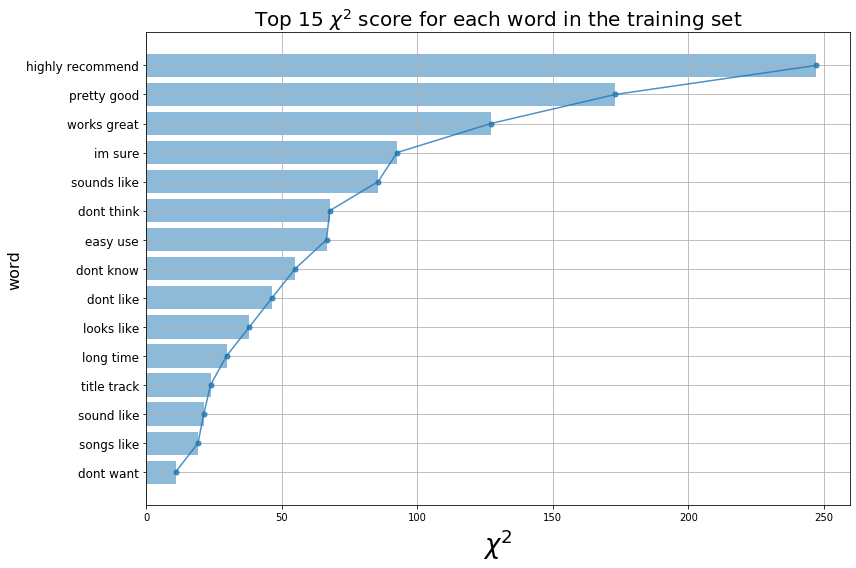

In [11]:
X_train_ = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lower=True, only_alpha=True, stop_words=stop_words)):
    X_train_[ix] = " ".join(processed_text)
    
cv = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_ = cv.fit_transform(X_train_)

draw_chi2(X_train_, y_train, cv)

Parece que funciona mejor al identificar bigramas que sí que evidencian una relación con la valoración que se está haciendo, aunque me veo obligado a reducir mucho el juego que pueda tener con min_df y max_df, voy a probar estos mismos parámetros pero utilizando un preprocesado diferente.

Igual que antes pero además lematizando las palabras:

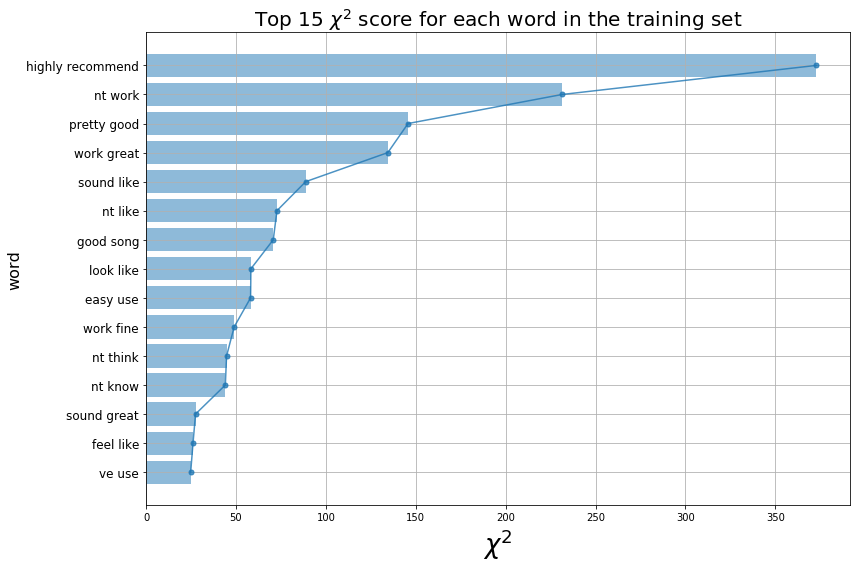

In [12]:
X_train_lemma = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lemmatizer=spacy_lemmas,
                                               lower=True, only_alpha=True, stop_words=stop_words)):
    X_train_lemma[ix] = " ".join(processed_text)
    
cv_lemma = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_lemma = cv_lemma.fit_transform(X_train_lemma)

draw_chi2(X_train_lemma, y_train, cv_lemma)

Lo mismo pero sin lematizar y aplicando el preprocesado de gensim:

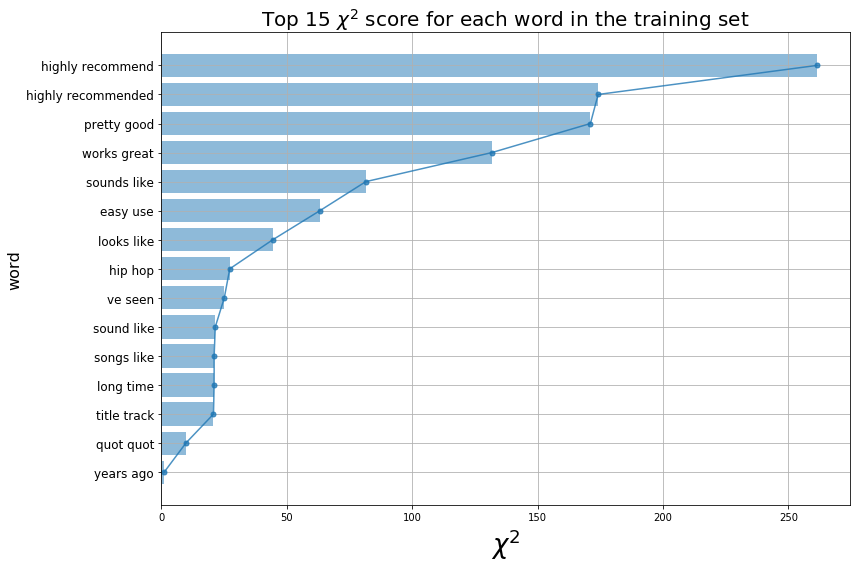

In [13]:
X_train_simple = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               simple_gensim=True, stop_words=stop_words)):
    X_train_simple[ix] = " ".join(processed_text)
    
cv_simple = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_simple = cv_simple.fit_transform(X_train_simple)

draw_chi2(X_train_simple, y_train, cv_simple)

Diría que mi favorito de todos estos es el que se consigue lematizando las palabras. Que se destaquen tanto palabras como "work", "recommend", "great", "like", "easy" y "good" parece una buena señal. Voy a entrenar un modelo con esos datos y a ver qué tal funciona.

In [14]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_lemma, y_train)
    
    train_predict = lr.predict(X_train_lemma)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_train, train_predict)))

Accuracy for C=0.01: 0.5996898759503801
Accuracy for C=0.05: 0.6030912364945978
Accuracy for C=0.25: 0.6034163665466187
Accuracy for C=0.5: 0.6033663465386154
Accuracy for C=1: 0.6032913165266106
Accuracy for C=10: 0.603266306522609
Accuracy for C=100: 0.603266306522609
Accuracy for C=1000: 0.603266306522609
Accuracy for C=10000: 0.603266306522609


In [15]:
lr = LogisticRegression(C=0.25, max_iter=500)
lr.fit(X_train_lemma, y_train)
    
train_predict = lr.predict(X_train_lemma)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))

Confussion matrix:
[[  183   101  8769]
 [  120   201  6633]
 [  112   122 23743]]

Classification report:
              precision    recall  f1-score   support

        good       0.44      0.02      0.04      9053
 not_so_good       0.47      0.03      0.05      6954
   very_good       0.61      0.99      0.75     23977

    accuracy                           0.60     39984
   macro avg       0.51      0.35      0.28     39984
weighted avg       0.55      0.60      0.47     39984

Accuracy score:0.6034163665466187


A ver con un random forest si podemos sacar algo decente

best mean cross-validation score: 0.604
best parameters: {'max_depth': 14}


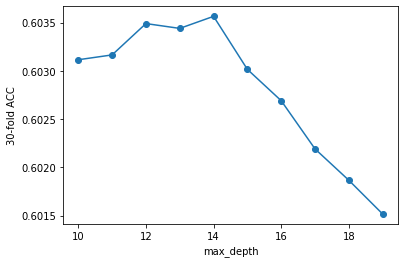

In [16]:
maxDepth = range(10,20)

gridRFC = GridSearchCV(RandomForestClassifier(n_estimators=200), param_grid={'max_depth': maxDepth}, cv=30)
gridRFC.fit(X_train_lemma, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFC.best_score_))
print("best parameters: {}".format(gridRFC.best_params_))

scores = np.array(gridRFC.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [17]:
maxDepthOptimo = gridRFC.best_params_['max_depth']

RFC = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200).fit(X_train_lemma, y_train)

train_predict = RFC.predict(X_train_lemma)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))

Confussion matrix:
[[  366    73  8614]
 [   67   357  6530]
 [   78    83 23816]]

Classification report:
              precision    recall  f1-score   support

        good       0.72      0.04      0.08      9053
 not_so_good       0.70      0.05      0.10      6954
   very_good       0.61      0.99      0.76     23977

    accuracy                           0.61     39984
   macro avg       0.67      0.36      0.31     39984
weighted avg       0.65      0.61      0.49     39984

Accuracy score:0.6137204881952781


Mejora un poco los resultados pero sigue sin ser gran cosa. ¿Y con word2vec?

In [18]:
# Imprimir palabras similares

def print_sim_words(word, model):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for sim in model.wv.most_similar(word):
        print("{}:{}{:.3f}{}".format(sim[0], " "*(20-len(sim[0])),
                                     sim[1], " "*10))
    print("\n")

Genero un diccionario y lo entreno con skip gram para conseguir una representación vectorial de cada palabra en base a su contexto

In [19]:
w2v_sg = Word2Vec(sg=1, size=300, min_count=10, window=10, hs=0, negative=20, workers=4)

train_corpus = preprocess_texts(X_train,
                          lemmatizer=spacy_lemmas,
                          lower=True, regex='[^a-zA-Z!]+', stop_words=stop_words, ngrams=(1,2))

w2v_sg.build_vocab(train_corpus)

w2v_sg.train(sentences=train_corpus, total_examples=w2v_sg.corpus_count, epochs=50)

(123940900, 217066200)

Echo un vistazo para ver si la contextualización tiene sentido

In [20]:
print_sim_words('recommend', w2v_sg)
print_sim_words('work', w2v_sg)
print_sim_words('great', w2v_sg)
print_sim_words('good', w2v_sg)
print_sim_words('car', w2v_sg)

Most similar to recommend
-------------------------
highly:              0.869          
highly recommend:    0.512          
great:               0.426          
definitely:          0.408          
use:                 0.402          
suggest:             0.398          
good:                0.389          
work:                0.375          
buy:                 0.375          
need:                0.373          


Most similar to work
--------------------
use:                 0.744          
need:                0.596          
job:                 0.590          
try:                 0.586          
like:                0.583          
fine:                0.579          
nt:                  0.570          
sure:                0.568          
way:                 0.567          
great:               0.566          


Most similar to great
---------------------
good:                0.795          
like:                0.693          
excellent:           0.669          
amazing

Ahora transformo todas las palabras de mi corpus en su vector correspondiente.

In [21]:
# Fijo a 100 tokens por registro ya que la mayoría de reviews tienen menos de 100 palabras.
# Si un texto tiene menos de 100 tokens los huecos se rellenan con ceros.
train_vector_corpus = np.zeros((len(train_corpus), 100, 300))

for i1 in range(len(train_corpus)):
    for i2 in range(200):
        try: train_vector_corpus[i1][i2] = w2v_sg.wv[train_corpus[i1][i2]]
        except: pass

Aplico la misma transformación a test

In [22]:
test_corpus = preprocess_texts(X_test,
                               lemmatizer=spacy_lemmas,
                               lower=True, regex='[^a-zA-Z!]+', stop_words=stop_words, ngrams=(1,2))

test_vector_corpus = np.zeros((len(test_corpus), 100, 300))

for i1 in range(len(test_corpus)):
    for i2 in range(200):
        try: test_vector_corpus[i1][i2] = w2v_sg.wv[test_corpus[i1][i2]]
        except: pass

Entreno y valido los datos

In [23]:
y_train_int = y_train.apply(lambda x: 2 if x == 'very_good' else 1 if x == 'good' else 0)
y_test_int = y_test.apply(lambda x: 2 if x == 'very_good' else 1 if x == 'good' else 0)

model = Sequential()
model.add(LSTM(512, input_shape=(train_vector_corpus.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_vector_corpus, y_train_int, validation_split=0.1, epochs=20, batch_size=1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 35985 samples, validate on 3999 samples
Epoch 1/20
35985/35985 [==============================] - 118s 3ms/step - loss: 0.9623 - accuracy: 0.5886 - val_loss: 0.9311 - val_accuracy: 0.6017
Epoch 2/20
35985/35985 [==============================] - 84s 2ms/step - loss: 0.9438 - accuracy: 0.5994 - val_loss: 0.9324 - val_accuracy: 0.6017
Epoch 3/20
35985/35985 [==============================] - 85s 2ms/step - loss: 0.9319 - accuracy: 0.5994 - val_loss: 0.8964 - val_accuracy: 0.6017
Epoch 4/20
35985/35985 [==============================] - 81s 2ms/step - loss: 0.8951 - accuracy: 0.5994 - val_loss: 0.8576 - val_accuracy: 0.6177
Epoch 5/20
35985/35985 [==============================] - 81s 2ms/step - loss: 0.8729 - accuracy: 0.6049 - val_loss: 0.8434 - val_accuracy: 0.6282
Epoch 6/20
35985/35985 [==============================] - 80s 2ms/step - loss: 0.8472 - accurac

Veamos qué resultados nos arroja el corpus de testeo

In [25]:
predict = model.predict(test_vector_corpus)
test_predict = [max(range(len(probs)), key=probs.__getitem__) for probs in predict]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test_int, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test_int, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test_int, test_predict)))

Confussion matrix:
[[ 693   54  964]
 [ 254   72 2063]
 [ 159   45 5693]]

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.49      1711
           1       0.42      0.03      0.06      2389
           2       0.65      0.97      0.78      5897

    accuracy                           0.65      9997
   macro avg       0.57      0.47      0.44      9997
weighted avg       0.59      0.65      0.56      9997

Accuracy score:0.6459937981394418


Es interesante ver que parece que sabe hacer cierta distinción entre críticas positivas y negativas (sobretodo teniendo en cuenta que aquí ya estamos viendo los datos de test y que el porcentaje de críticas negativas es muy pequeño), aunque no parece saber distinguir tan bien entre críticas "positivas" y "muy positivas". Esto puede indicar que probablemente las reviews de 4 y 5 estrellas son muy parecidas en el vocabulario que utilizan.

In [82]:
predictions = []
for pred in test_predict:
    if pred == 2: predictions.append('very_good')
    if pred == 1: predictions.append('good')
    if pred == 0: predictions.append('not_so_good')

print('Predicciones              Real\n-------------------------------------')
for cat in ('very_good','good','not_so_good'):
    print(f'{cat:>11}: {Counter(predictions)[cat]:<10} {cat:>11}: {Counter(y_test)[cat]}')
print('_____________________________________')
for pred,real in zip(predictions,y_test):
    print(f'{pred:>12}        {real:>15}')

Predicciones              Real
-------------------------------------
  very_good: 8720         very_good: 5897
       good: 171               good: 2389
not_so_good: 1106       not_so_good: 1711
_____________________________________
   very_good              very_good
   very_good                   good
 not_so_good            not_so_good
   very_good                   good
   very_good              very_good
   very_good              very_good
 not_so_good                   good
   very_good              very_good
   very_good              very_good
   very_good            not_so_good
   very_good                   good
   very_good              very_good
   very_good            not_so_good
   very_good                   good
        good                   good
   very_good              very_good
   very_good              very_good
   very_good            not_so_good
   very_good              very_good
   very_good                   good
   very_good              very_good
   very_goo

   very_good                   good
   very_good              very_good
   very_good                   good
   very_good              very_good
 not_so_good              very_good
 not_so_good                   good
   very_good                   good
   very_good              very_good
   very_good                   good
   very_good              very_good
   very_good                   good
   very_good              very_good
   very_good              very_good
   very_good              very_good
 not_so_good                   good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good                   good
   very_good                   good
   very_good              very_good
   very_good            not_so_good
   very_good                   good
   very_good              very_good
   very_good              very_good
 not_so_good            not_so_good
   very_good              ve

   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
   very_good                   good
   very_good              very_good
   very_good              very_good
   very_good                   good
 not_so_good            not_so_good
   very_good                   good
   very_good              very_good
   very_good                   good
   very_good                   good
   very_good              very_good
 not_so_good            not_so_good
        good            not_so_good
   very_good              very_good
   very_good              very_good
   very_good              very_good
 not_so_good                   good
 not_so_good                   good
   very_good              very_good
   very_good                   good
   very_good              ve